## Notebook 3: Multimodal Evaluation

[Click to view on Google Colab](https://colab.research.google.com/drive/1FR9Ua8VoAPI-nYlgXagiRhOSGq40cDGC?usp=sharing)
  
### Metrics Used:
- CLIP: Score ranges from 0-100 (higher = better)
- BLEU: Score ranges from 0-1 (higher = better)


---

### Import the Libraries

In [2]:
!pip install matplotlib torchmetrics torchvision evaluate

import os
import random
import matplotlib.pyplot as plt
from torchmetrics.multimodal.clip_score import CLIPScore
from PIL import Image
import torchvision.transforms as transforms
import evaluate

# Fix tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore", message=".*use_fast.*")

---

### Image Preprocessing

Converts PIL images to tensors compatible with CLIP scoring. Standardizes image format to 224x224 pixels and proper tensor format for evaluation.

In [3]:
def preprocess_image(image):
    """Convert PIL image to tensor for CLIP Score"""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 255).byte())
    ])
    return transform(image)

---

### Sample Generation

Creates synthetic image-caption pairs for demonstration:
- Solid colored squares (red, blue, green)
- Simple geometric patterns (circles, stripes)
- Utility functions for random sampling and display

In [4]:
def create_simple_pattern(color_rgb, pattern_type):
    """Create simple patterned images"""
    img = Image.new('RGB', (224, 224), 'white')
    pixels = img.load()
    
    if pattern_type == 'circle':
        # Draw a simple circle
        center_x, center_y = 112, 112
        radius = 80
        for x in range(224):
            for y in range(224):
                if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                    pixels[x, y] = color_rgb
    
    elif pattern_type == 'stripes':
        # Draw horizontal stripes
        for x in range(224):
            for y in range(224):
                if (y // 20) % 2 == 0:  # Every 20 pixels
                    pixels[x, y] = color_rgb
    
    return img


def create_sample_examples():
    """Create simple sample examples for demo"""
    examples = [
        {
            "image": Image.new('RGB', (224, 224), 'red'),
            "caption": "A red colored square"
        },
        {
            "image": Image.new('RGB', (224, 224), 'blue'),
            "caption": "A blue colored square"
        },
        {
            "image": Image.new('RGB', (224, 224), 'green'),
            "caption": "A green colored square"
        },
        {
            "image": create_simple_pattern((255, 255, 0), 'circle'),
            "caption": "A yellow colored circle on white background"
        },
        {
            "image": create_simple_pattern((128, 0, 128), 'stripes'),
            "caption": "Purple and white colored stripes"
        }
    ]
    return examples

def get_random_example():
    """Get a random image-caption pair"""
    examples = create_sample_examples()
    example = random.choice(examples)
    print("✅ Generated synthetic example")
    return example["image"], example["caption"]

def display_image(image, caption=None):
    """Display image with optional caption"""
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    if caption:
        plt.title(f"Caption: '{caption}'", fontsize=12, pad=20)
    plt.show()

---

### Evaluation

Core evaluation functions implementing:
- **CLIP Score**: Measures semantic similarity between images and text
- **Caption Comparison**: Evaluates multiple captions against single image
- **Demo Functions**: Interactive examples showing evaluation in action

In [5]:
def evaluate_caption(image, caption):
    """Test a caption against an image and return score"""
    image_tensor = preprocess_image(image)
    metric = CLIPScore("openai/clip-vit-base-patch16")
    score = metric(image_tensor, caption)
    return score.item()

def compare_captions(image, captions):
    """Compare multiple captions for the same image"""
    print("📊 Comparing captions:")
    print("-" * 30)
    
    scores = []
    for i, caption in enumerate(captions, 1):
        score = evaluate_caption(image, caption)
        print(f"{i}. '{caption}' → {score:.1f}")
        scores.append(score)
    
    print(f"\nBest score: {max(scores):.1f}")
    print(f"Worst score: {min(scores):.1f}")
    return scores

# Example usage functions
def demo_clip_basic():
    """Basic demo - load image and test original caption"""
    print("🚀 Basic CLIP Score Demo")
    image, caption = get_random_example()
    display_image(image, caption)
    score = evaluate_caption(image, caption)
    print(f"Original caption score: {score:.1f}")
    return image, caption

def demo_clip_comparison():
    """Demo comparing multiple captions"""
    print("🚀 Caption Comparison Demo")
    image, original_caption = get_random_example()
    display_image(image, original_caption)
    
    # Test multiple captions
    test_captions = [
        original_caption,
        "A car driving on a road",
        "A human playing a guitar",
        "A colorful image"
    ]
    
    scores = compare_captions(image, test_captions)
    return image, test_captions, scores

🚀 Basic CLIP Score Demo
✅ Generated synthetic example


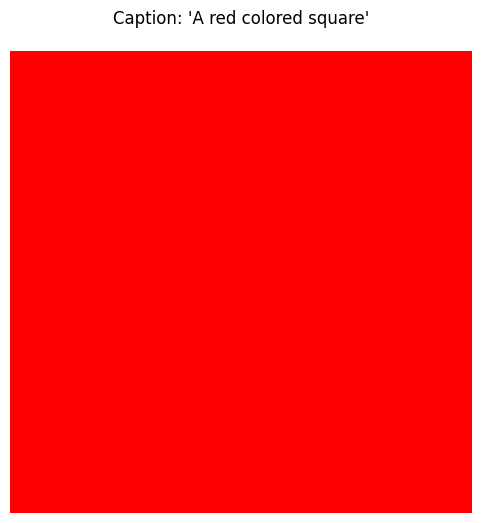

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Original caption score: 31.2


(<PIL.Image.Image image mode=RGB size=224x224>, 'A red colored square')

In [6]:
demo_clip_basic()

🚀 Caption Comparison Demo
✅ Generated synthetic example


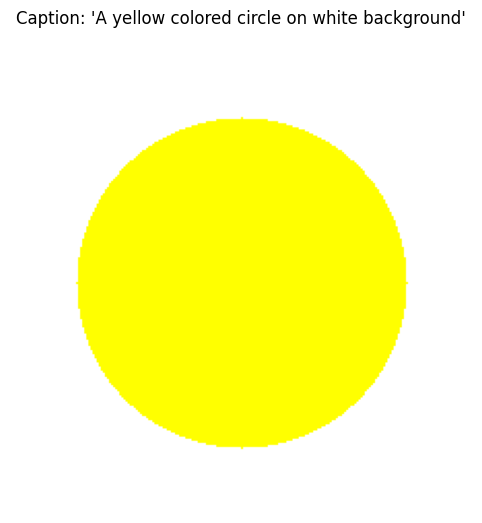

📊 Comparing captions:
------------------------------
1. 'A yellow colored circle on white background' → 36.5
2. 'A car driving on a road' → 22.8
3. 'A human playing a guitar' → 20.8
4. 'A colorful image' → 25.8

Best score: 36.5
Worst score: 20.8


(<PIL.Image.Image image mode=RGB size=224x224>,
 ['A yellow colored circle on white background',
  'A car driving on a road',
  'A human playing a guitar',
  'A colorful image'],
 [36.54759216308594,
  22.758098602294922,
  20.802528381347656,
  25.84286880493164])

In [7]:
demo_clip_comparison()

---

### BLEU Score Demonstration

Comparison between BLEU and CLIP metrics:
- **Exact Match Requirement**: BLEU needs precise word overlap
- **Semantic Understanding**: CLIP captures meaning beyond exact words
- **Practical Implications**: Shows why CLIP is better for multimodal evaluation

In [8]:
def demo_bleu_simple():
    """Simple BLEU score demonstration with clear examples"""
    print("🚀 Simple BLEU Demo")
    print("BLEU measures exact word overlap (0-1 scale)")
    print("=" * 40)
    
    bleu_metric = evaluate.load("bleu")
    # Get example
    image, reference = get_random_example()
    display_image(image, reference)
    
    print(f"Reference: '{reference}'")
    print("\nTesting 3 simple cases:")
    print("-" * 30)
    
    # Simple test cases
    test_cases = [
        (reference, "Identical text"),
        (reference.replace("colored", "color"), "One word changed"),
        ("Something completely different", "Totally different")
    ]
    
    for candidate, description in test_cases:
        # BLEU score
        bleu_result = bleu_metric.compute(
            predictions=[candidate], 
            references=[[reference]]
        )
        bleu_score = bleu_result['bleu']
        
        # CLIP score
        clip_score_val = evaluate_caption(image, candidate)
        
        print(f"Test: {description}")
        print(f"Text: '{candidate}'")
        print(f"BLEU: {bleu_score:.3f} | CLIP: {clip_score_val:.1f}")
        print()
    
    print("💡 Key Point:")
    print("BLEU needs exact word matches. Even small changes → BLEU = 0")
    print("CLIP understands meaning, so similar concepts get higher scores")

🚀 Simple BLEU Demo
BLEU measures exact word overlap (0-1 scale)
✅ Generated synthetic example


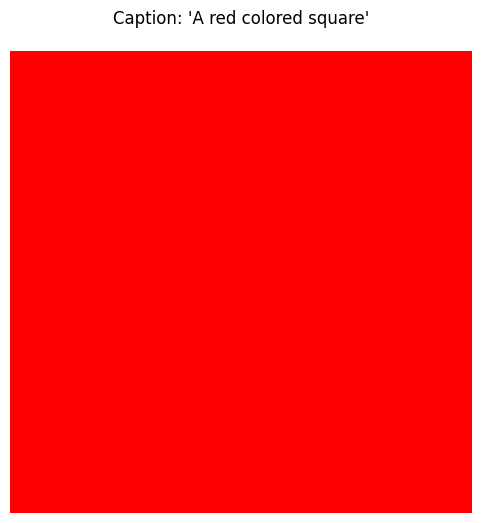

Reference: 'A red colored square'

Testing 3 simple cases:
------------------------------
Test: Identical text
Text: 'A red colored square'
BLEU: 1.000 | CLIP: 31.2

Test: One word changed
Text: 'A red color square'
BLEU: 0.000 | CLIP: 31.8

Test: Totally different
Text: 'Something completely different'
BLEU: 0.000 | CLIP: 20.6

💡 Key Point:
BLEU needs exact word matches. Even small changes → BLEU = 0
CLIP understands meaning, so similar concepts get higher scores


In [9]:
demo_bleu_simple()

---